In [1]:
# %pip install matplotlib seaborn numpy pandas
# %pip install optuna plotly
# %pip install nbformat

In [2]:
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd

In [3]:
from environment import AdaptiveGridWorld
from agents import DynaQAgent, DynaQPlusAgent, QLearningAgent
from simulator import Simulator

## Parameters

In [4]:
grid_size = (8, 8)
num_episodes = 1000
learning_rate = 0.2
max_steps_per_episode = 40
state_size = grid_size[0] * grid_size[1]
action_size = 4
lava_penalty = -10
small_reward_value = 5
boundary_penalty = -5
changes = [300, 600]
forgetfulness = 150
num_planning = 3
seed = 1998


def setup_env():
    initial_goal = (7, 7)

    # For each special cell, we define a mean reward. Any cell not listed => mean -1
    reward_means = {
        initial_goal: 15.0,
    }

    lava_pools = [(2, 2), (7, 3)]

    # Define initial small rewards
    small_reward_blocks = [(1, 1), (3, 5)]

    # Adaptive changes after certain episodes
    env_changes = {
        changes[0]: {
            "add_lava_pools": [(5, 5), (2, 3), (3, 7)],
            "remove_lava_pools": [(2, 2), (7, 3)],
            "add_small_reward_blocks": [(5, 1), (7, 5), (3, 0)],
            "remove_small_reward_blocks": [(1, 1)],
        },
        changes[1]: {
            "add_lava_pools": [(1, 4), (6, 1)],
            "remove_lava_pools": [(2, 3), (5, 5)],
            "add_small_reward_blocks": [(2, 1), (3, 3), (5, 4)],
            "remove_small_reward_blocks": [(5, 1), (3, 0), (3, 5)],
        },
    }

    return initial_goal, reward_means, lava_pools, small_reward_blocks, env_changes

## Q-Learning with Epsilon-greedy exploration

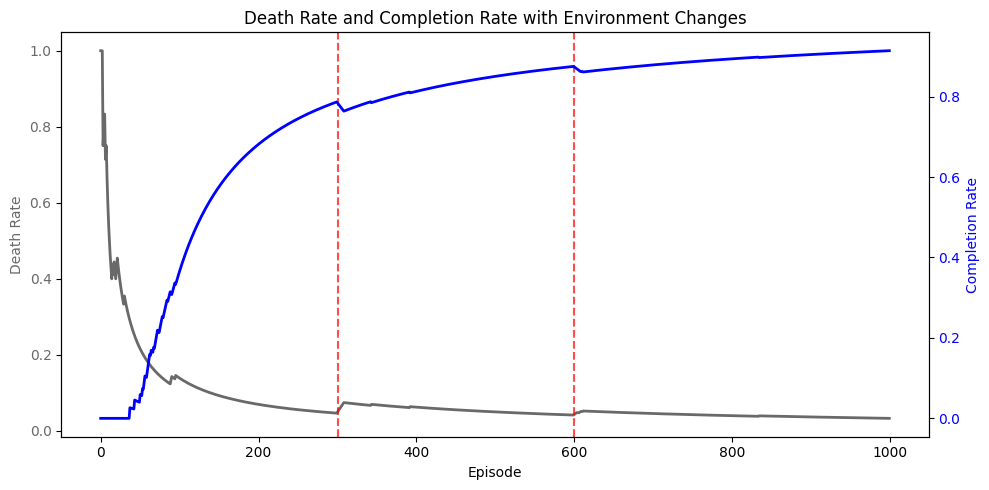

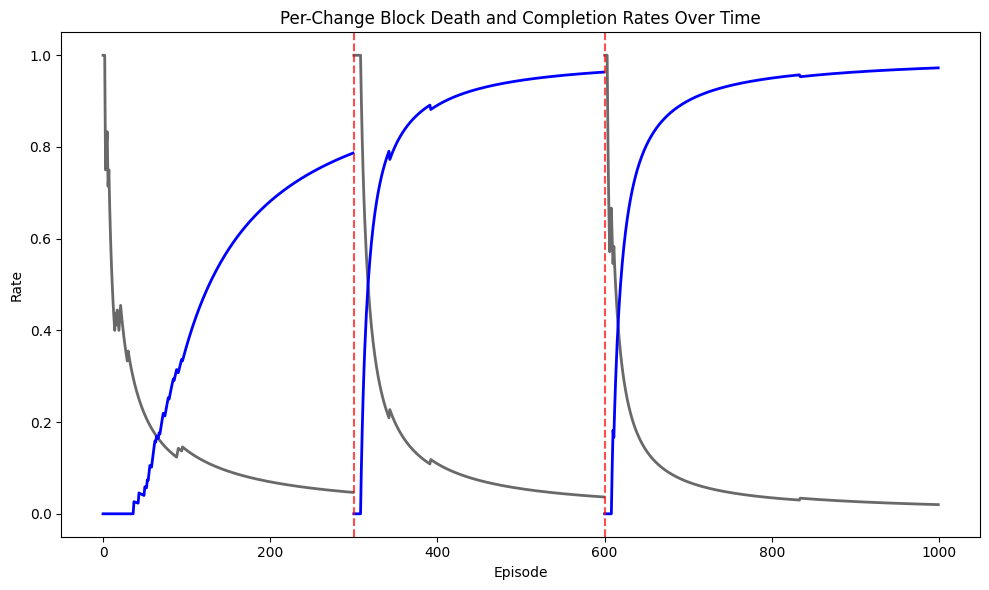

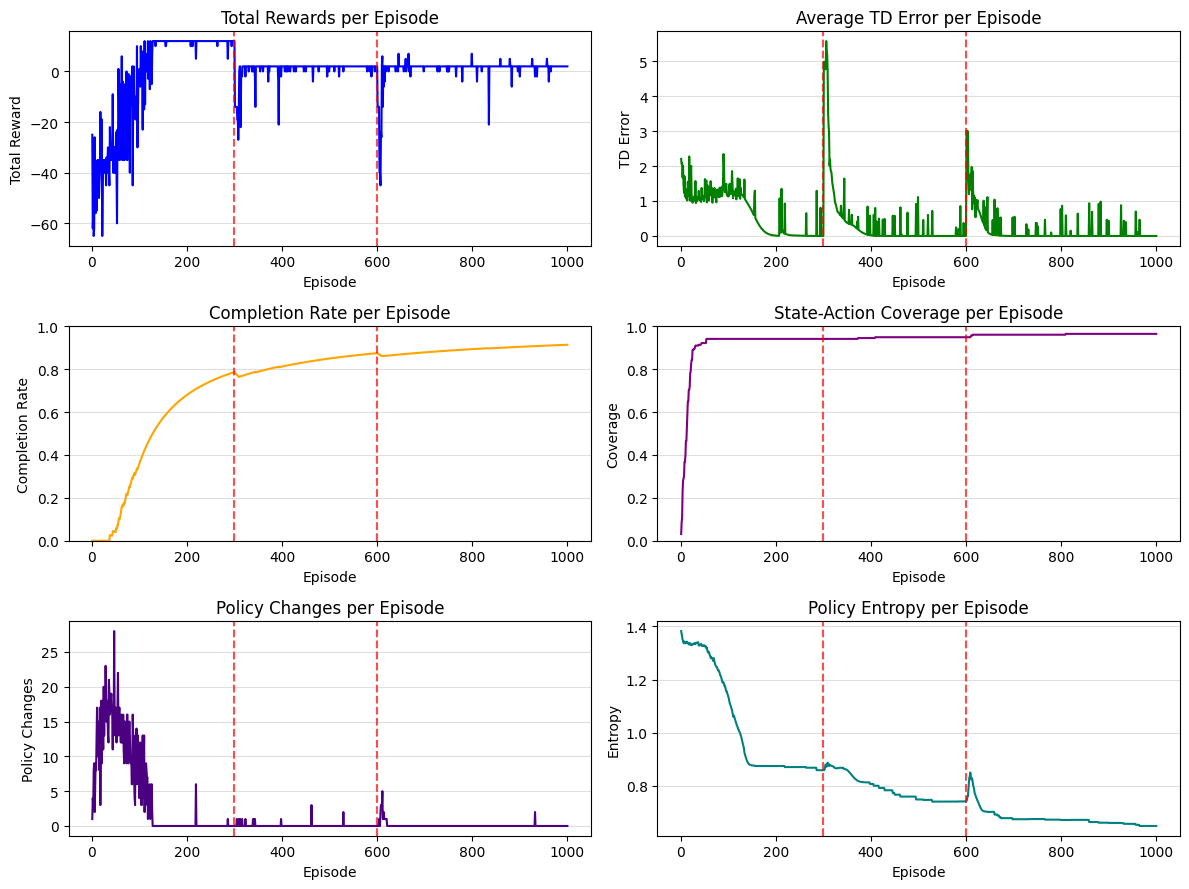

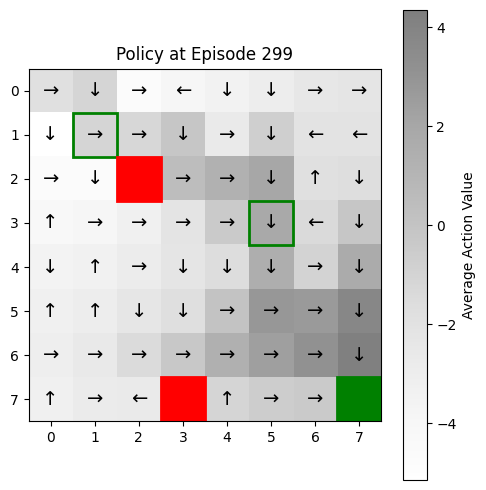

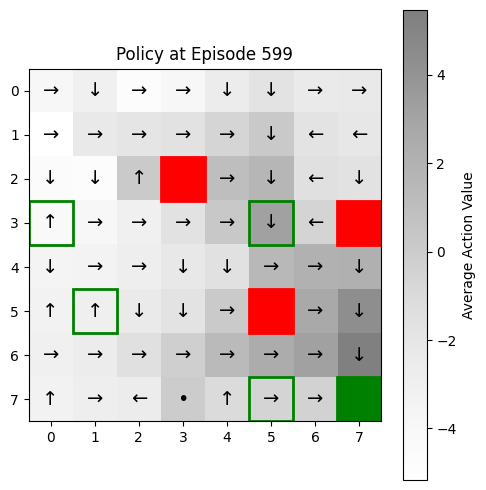

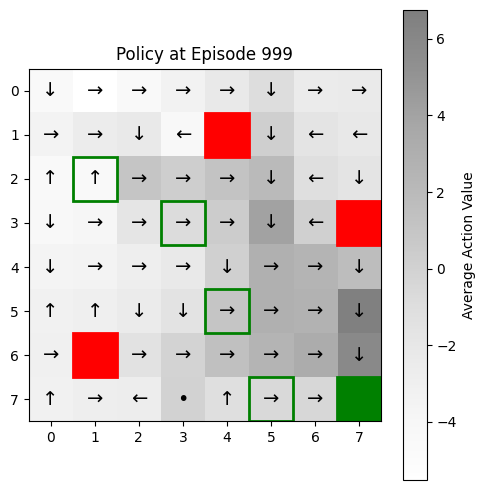

In [5]:
def q_learning(seed, plot=True):
    np.random.seed(seed)
    random.seed(seed)

    # Instantiate the environment
    initial_goal, reward_means, lava_pools, small_reward_blocks, env_changes = (
        setup_env()
    )
    env = AdaptiveGridWorld(
        size=grid_size,
        initial_goal=initial_goal,
        small_reward_blocks=small_reward_blocks.copy(),
        reward_means=reward_means,
        lava_penalty=lava_penalty,
        lava_pools=lava_pools.copy(),
        changes=env_changes,
        boundary_penalty=boundary_penalty,
        small_reward_value=small_reward_value,
    )

    # Initialise agent
    agent = QLearningAgent(
        state_size=state_size,
        action_size=action_size,
        episodes=num_episodes,
        epsilon_decay="exponential",
        learning_rate=learning_rate,
    )

    # Run simulation
    simulator = Simulator(
        env, agent, episodes=num_episodes, steps_per_episode=max_steps_per_episode
    )
    simulator.run()

    if plot:
        # Evaluate results
        simulator.plot_death_and_completion_rates_with_changes()
        simulator.plot_time_series_per_change()
        simulator.plot_metrics()

        for epi in [changes[0] - 1, changes[1] - 1, num_episodes - 1]:
            simulator.plot_policy_at_episode(episode=epi)

    return simulator, agent


simulator, agent = q_learning(seed=seed)

In [6]:
# simulator.animate_agent_value_heatmaps(interval=1, filename="images/q_learn_animated")

## Dyna-Q/ Tabular Dyna

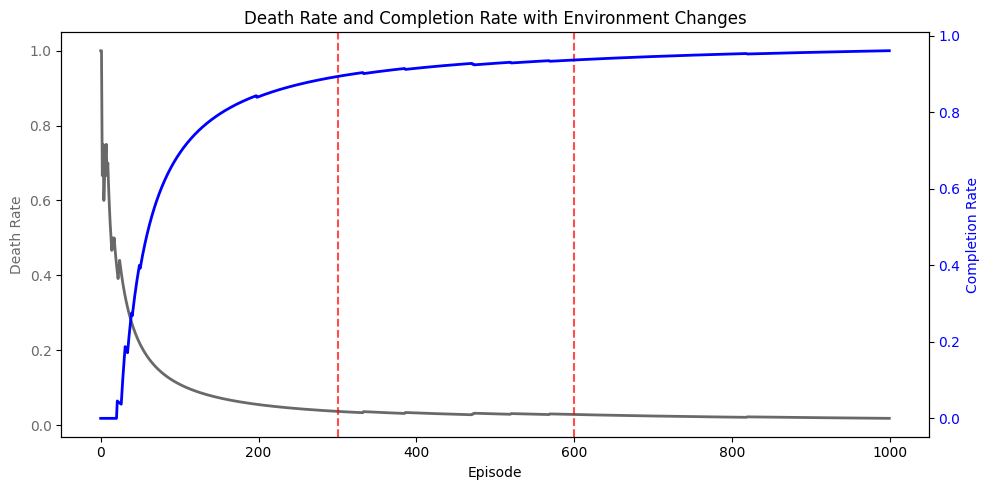

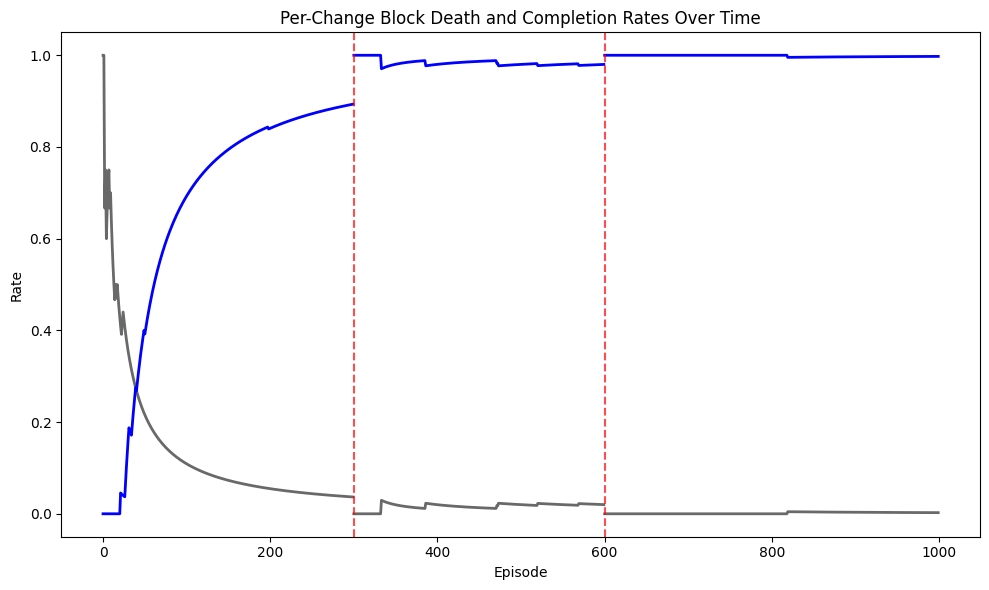

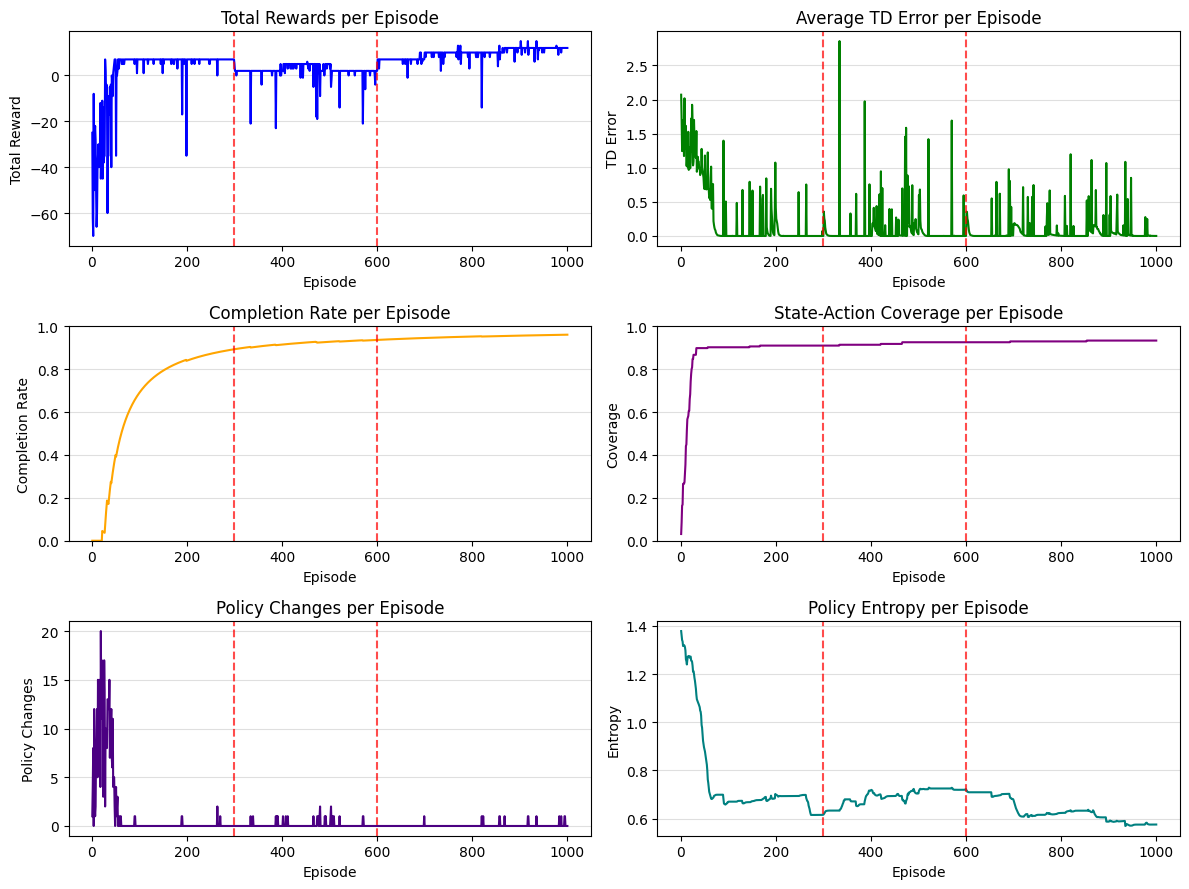

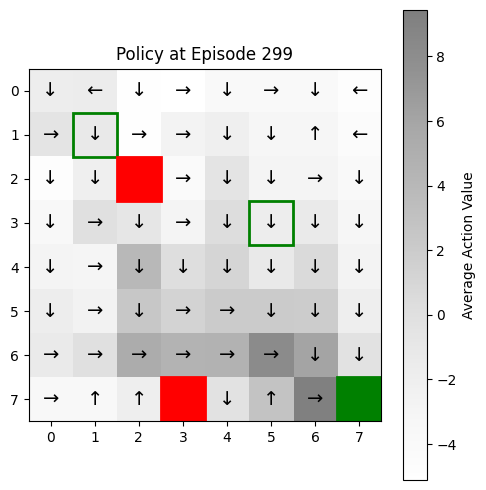

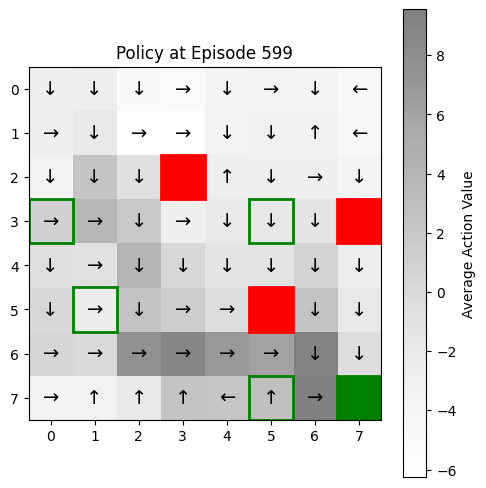

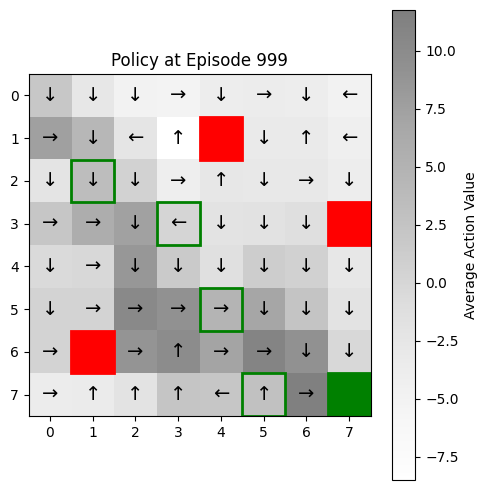

In [7]:
def dyna_q(seed, plot=True):
    np.random.seed(seed)
    random.seed(seed)

    initial_goal, reward_means, lava_pools, small_reward_blocks, env_changes = (
        setup_env()
    )
    env = AdaptiveGridWorld(
        size=grid_size,
        initial_goal=initial_goal,
        small_reward_blocks=small_reward_blocks.copy(),
        reward_means=reward_means,
        lava_penalty=lava_penalty,
        lava_pools=lava_pools.copy(),
        changes=env_changes,
        boundary_penalty=boundary_penalty,
        small_reward_value=small_reward_value,
    )

    # Instantiate the agent
    dyna_agent = DynaQAgent(
        state_size=state_size,
        action_size=action_size,
        episodes=num_episodes,
        epsilon_decay="exponential",
        planning_steps=num_planning,
        prioritised_sweeping=False,
        forgetting_threshold=forgetfulness,
        learning_rate=learning_rate,
    )

    # Run simulation
    sim_dyna = Simulator(
        env, dyna_agent, episodes=num_episodes, steps_per_episode=max_steps_per_episode
    )
    sim_dyna.run()

    if plot:
        # Evaluate results
        sim_dyna.plot_death_and_completion_rates_with_changes()
        sim_dyna.plot_time_series_per_change()
        sim_dyna.plot_metrics()

        for epi in [changes[0] - 1, changes[1] - 1, num_episodes - 1]:
            sim_dyna.plot_policy_at_episode(episode=epi)

    return sim_dyna, dyna_agent


sim_dyna, dyna_agent = dyna_q(seed=seed)

In [8]:
# sim_dyna.animate_agent_value_heatmaps(interval=1, filename="dyna_q_animated")

## Dyna-Q+

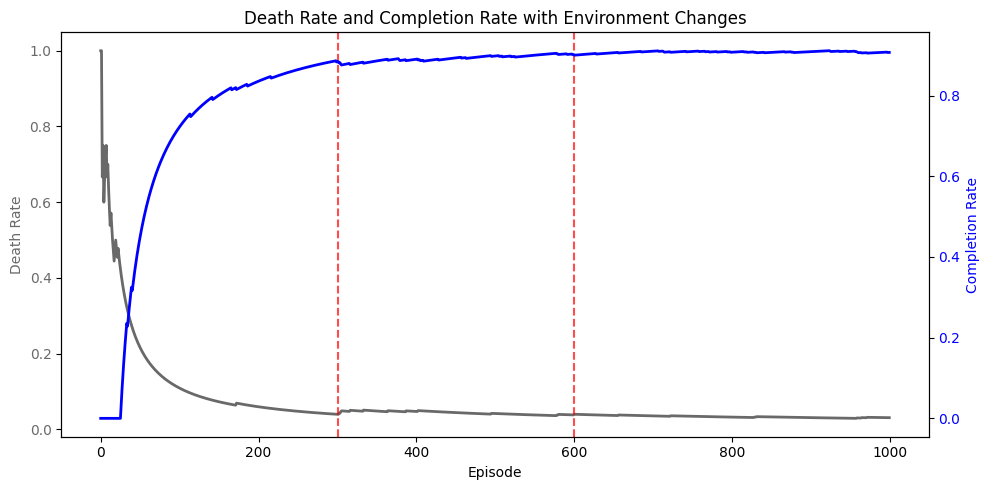

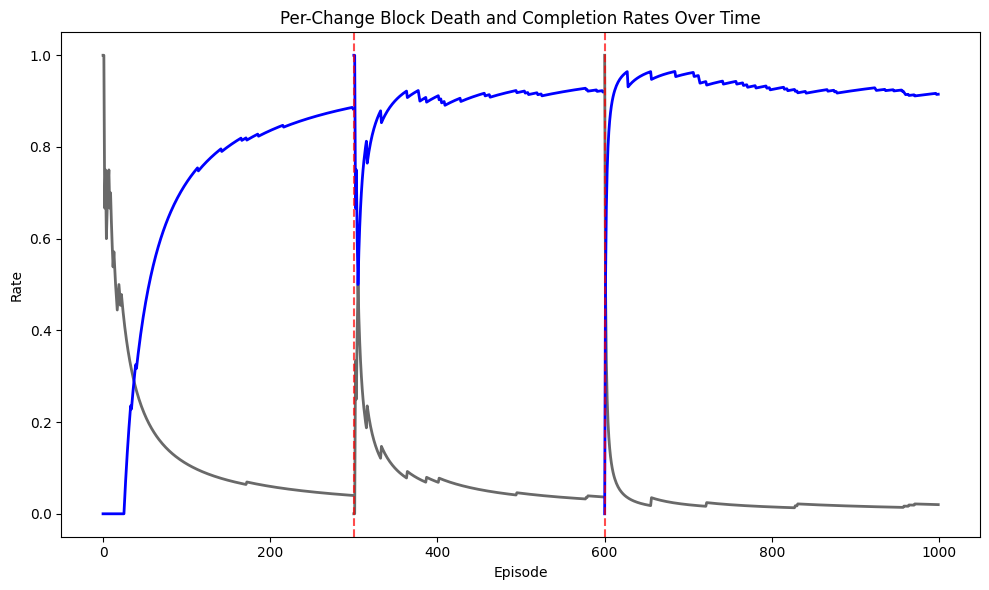

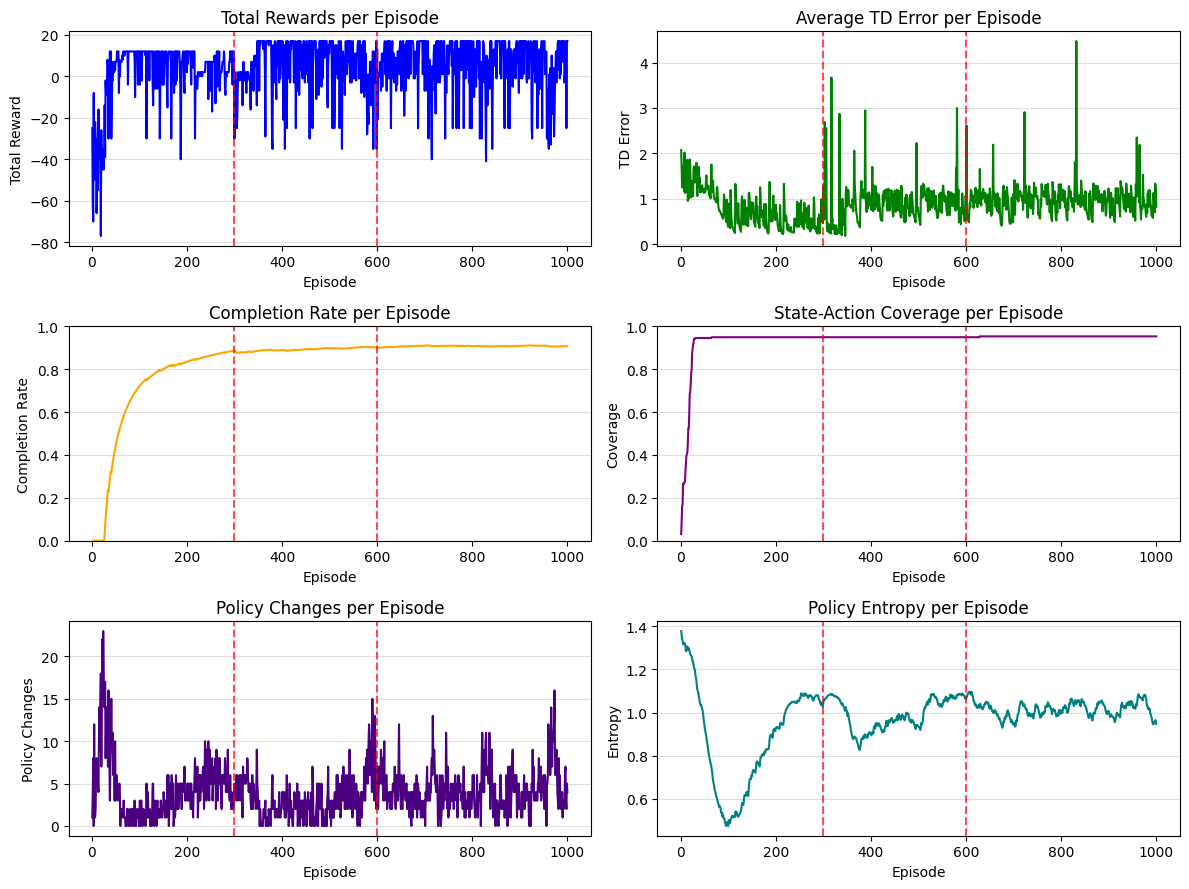

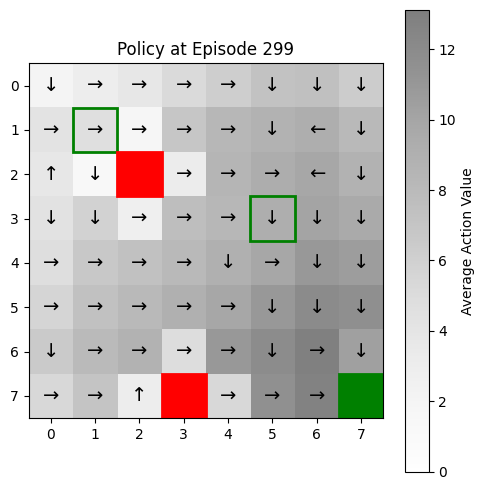

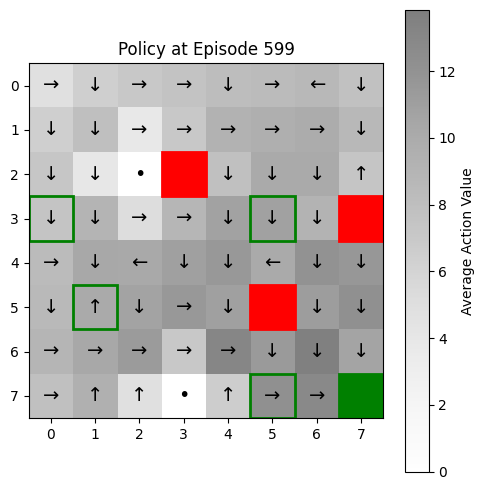

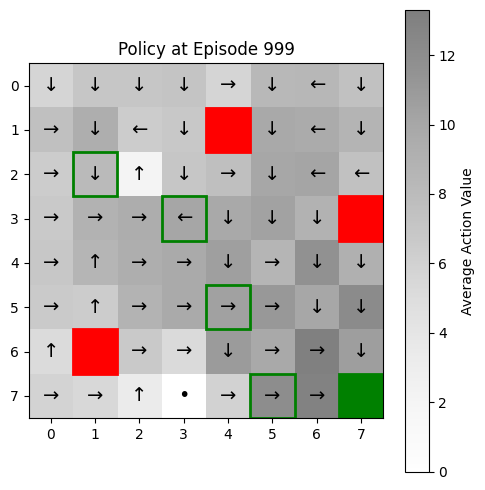

In [9]:
def dyna_q_plus(seed, plot=True):
    np.random.seed(seed)
    random.seed(seed)

    initial_goal, reward_means, lava_pools, small_reward_blocks, env_changes = (
        setup_env()
    )
    env = AdaptiveGridWorld(
        size=grid_size,
        initial_goal=initial_goal,
        small_reward_blocks=small_reward_blocks.copy(),
        reward_means=reward_means,
        lava_penalty=lava_penalty,
        lava_pools=lava_pools.copy(),
        changes=env_changes,
        boundary_penalty=boundary_penalty,
        small_reward_value=small_reward_value,
    )

    # Instantiate the agent
    dyna_agent_plus = DynaQPlusAgent(
        state_size=state_size,
        action_size=action_size,
        episodes=num_episodes,
        epsilon_decay="exponential",
        planning_steps=num_planning,
        learning_rate=learning_rate,
        novelty_bonus_weight=0.01,
    )

    # Run simulation
    sim_dyna_plus = Simulator(
        env,
        dyna_agent_plus,
        episodes=num_episodes,
        steps_per_episode=max_steps_per_episode,
    )
    sim_dyna_plus.run()

    if plot:
        # Evaluate results
        sim_dyna_plus.plot_death_and_completion_rates_with_changes()
        sim_dyna_plus.plot_time_series_per_change()
        sim_dyna_plus.plot_metrics()

        for epi in [changes[0] - 1, changes[1] - 1, num_episodes - 1]:
            sim_dyna_plus.plot_policy_at_episode(episode=epi)

    return sim_dyna_plus, dyna_agent_plus


sim_dyna_plus, dyna_agent_plus = dyna_q_plus(seed=seed)

## Dyna-Q with prioritised sweeping

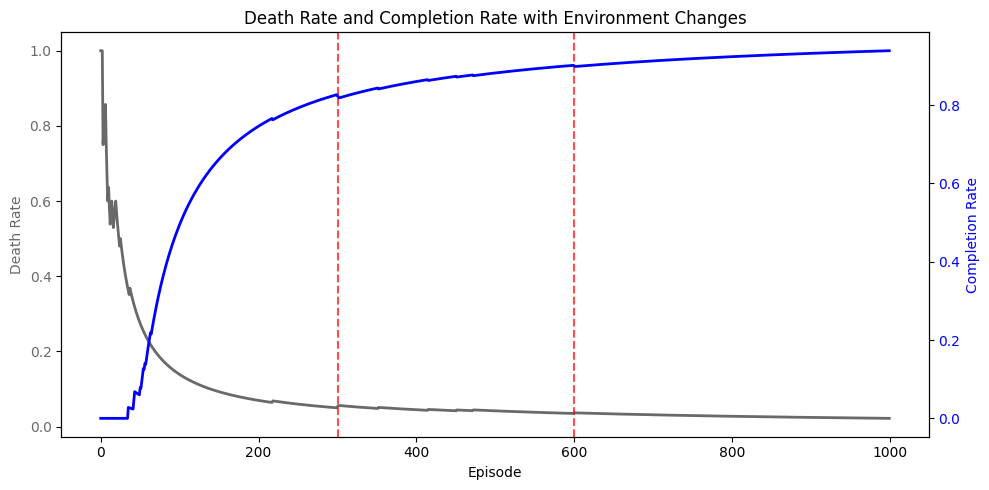

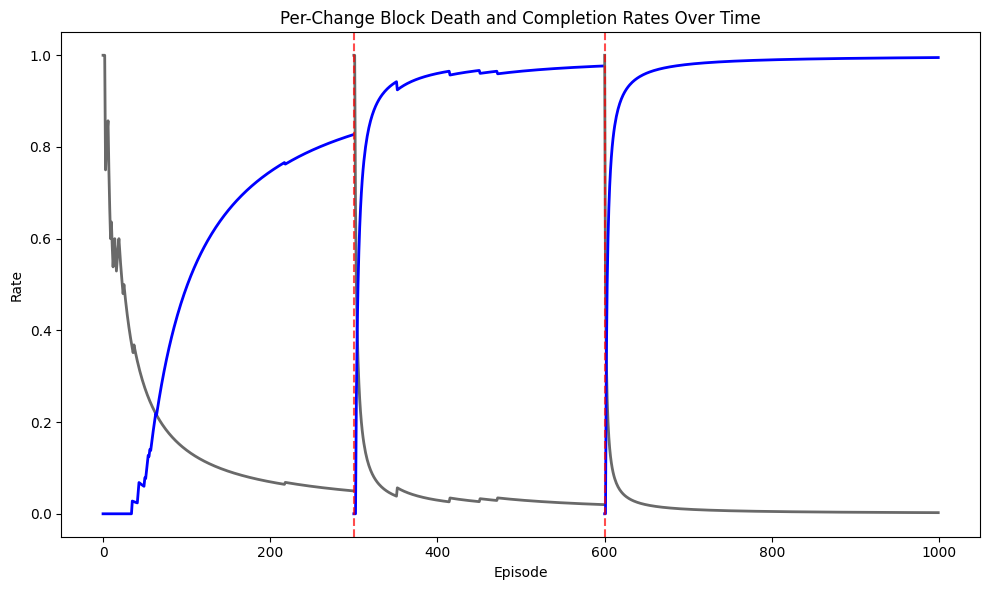

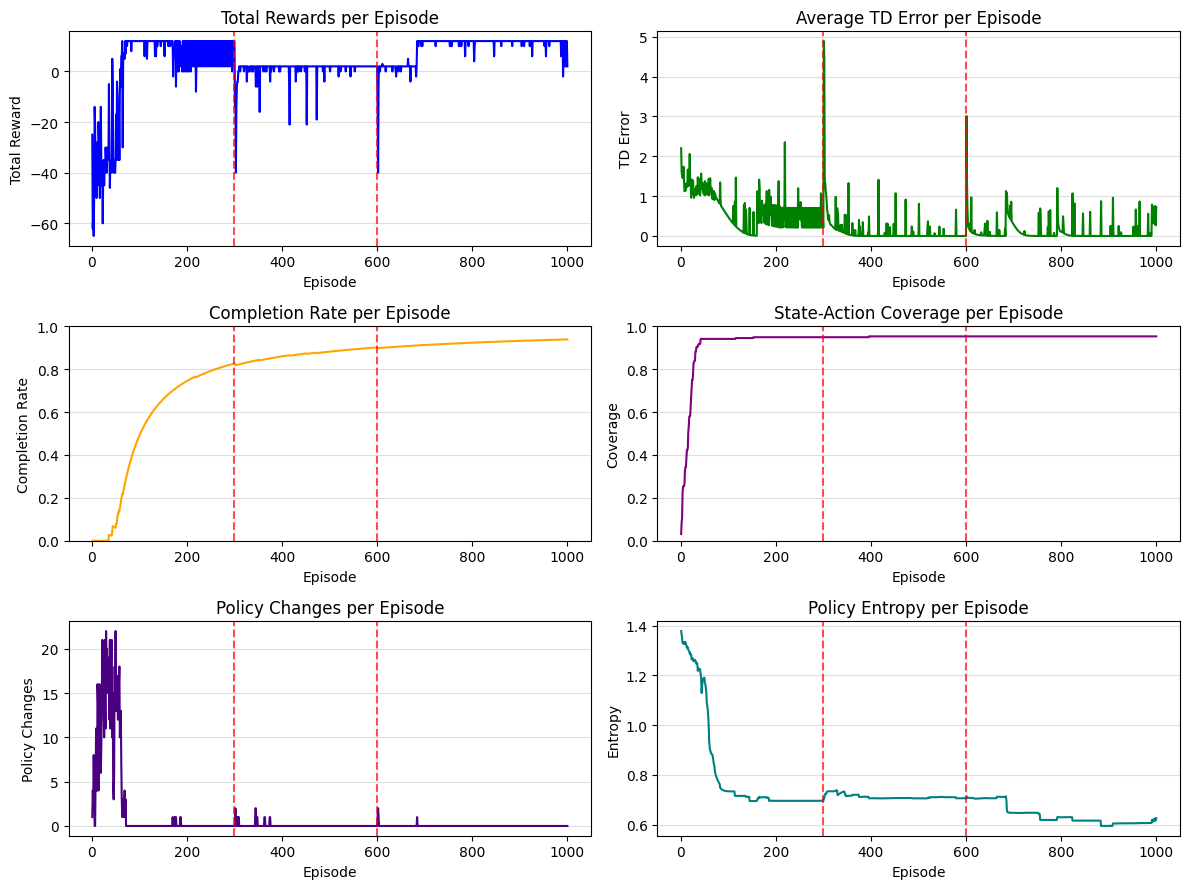

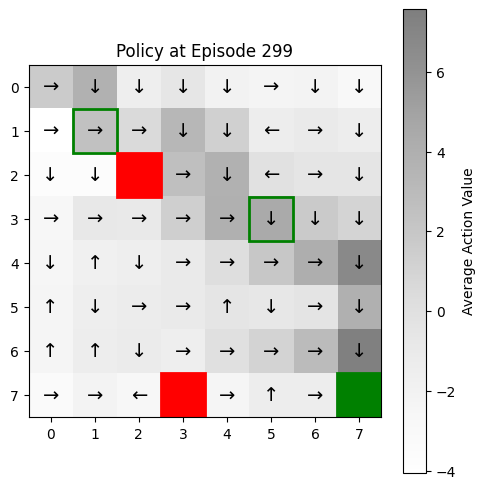

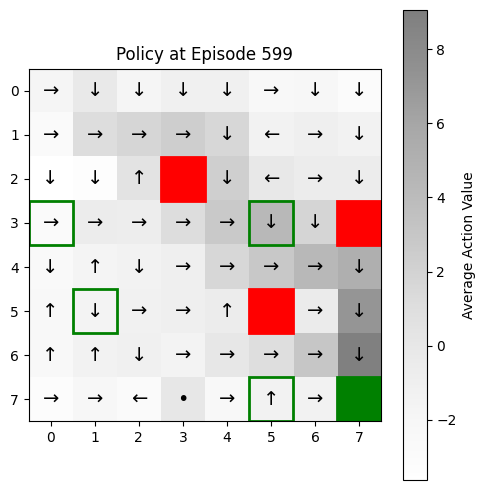

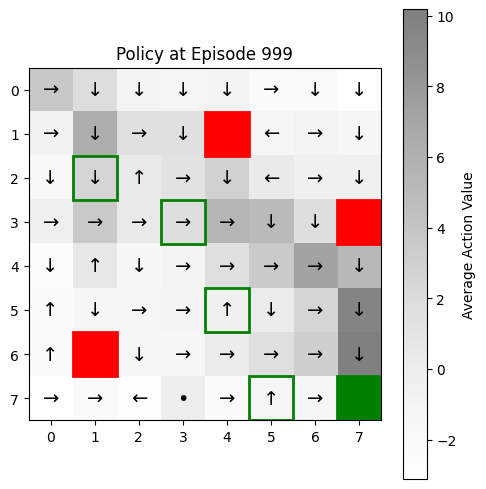

In [10]:
def dyna_q_sweep(seed, plot=True):
    np.random.seed(seed)
    random.seed(seed)

    initial_goal, reward_means, lava_pools, small_reward_blocks, env_changes = (
        setup_env()
    )
    env = AdaptiveGridWorld(
        size=grid_size,
        initial_goal=initial_goal,
        small_reward_blocks=small_reward_blocks.copy(),
        reward_means=reward_means,
        lava_penalty=lava_penalty,
        lava_pools=lava_pools.copy(),
        changes=env_changes,
        boundary_penalty=boundary_penalty,
        small_reward_value=small_reward_value,
    )

    # Instantiate the agent
    dyna_agent_sweep = DynaQAgent(
        state_size=state_size,
        action_size=action_size,
        episodes=num_episodes,
        epsilon_decay="exponential",
        planning_steps=num_planning,
        prioritised_sweeping=True,
        priority_threshold=1.5,
        forgetting_threshold=forgetfulness,
        learning_rate=learning_rate,
    )

    # Run simulation
    sim_dyna_sweep = Simulator(
        env,
        dyna_agent_sweep,
        episodes=num_episodes,
        steps_per_episode=max_steps_per_episode,
    )
    sim_dyna_sweep.run()

    if plot:
        # Evaluate results
        sim_dyna_sweep.plot_death_and_completion_rates_with_changes()
        sim_dyna_sweep.plot_time_series_per_change()
        sim_dyna_sweep.plot_metrics()

        for epi in [changes[0] - 1, changes[1] - 1, num_episodes - 1]:
            sim_dyna_sweep.plot_policy_at_episode(episode=epi)

    return sim_dyna_sweep, dyna_agent_sweep


sim_dyna_sweep, dyna_agent_sweep = dyna_q_sweep(seed=seed)

In [11]:
# sim_dyna_sweep.animate_agent_value_heatmaps(interval=1, filename="dyna_q_sweep_animated")

## Additional Plots

In [12]:
data = {
    "Q-Learning": simulator.total_rewards,
    "Dyna-Q": sim_dyna.total_rewards,
    "Dyna-Q+": sim_dyna_plus.total_rewards,
    # "Dyna-Q with Prioritised Sweeping": sim_dyna_sweep.total_rewards,
}

In [13]:
def plot_density(data, xlabel, loc="upper left", filename=None):
    plt.figure(figsize=(5, 4))
    colors = plt.cm.tab10(range(len(data)))  # Generate a color palette
    for idx, (label, values) in enumerate(data.items()):
        color = colors[idx]  # Get color for this dataset
        # Kernel Density Estimation (KDE) for smoother density curves
        kde = gaussian_kde(values, bw_method="scott")  # Silverman method for bandwidth
        x_vals = np.linspace(min(values), max(values), 1000)  # Range for smooth plot
        y_vals = kde(x_vals)

        # Plot histogram with transparency
        plt.hist(
            values,
            bins=30,
            density=True,
            alpha=0.5,
            color=color,
            label=label,
            histtype="stepfilled",
        )

        # Plot smoothed KDE line
        plt.plot(x_vals, y_vals, linestyle="-", color=color)

    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.legend(loc=loc)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

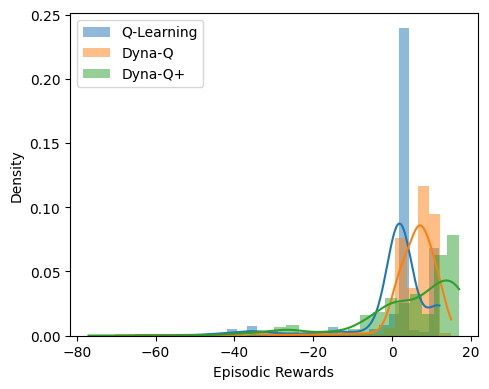

In [14]:
plot_density(data=data, xlabel="Episodic Rewards")

In [15]:
data = {
    "Q-Learning": simulator,
    "Dyna-Q: F": sim_dyna,
    # "Dyna-Q: F + PS": sim_dyna_sweep,
    "Dyna-Q+": sim_dyna_plus,
}
save = True
algorithms = list(data.keys())

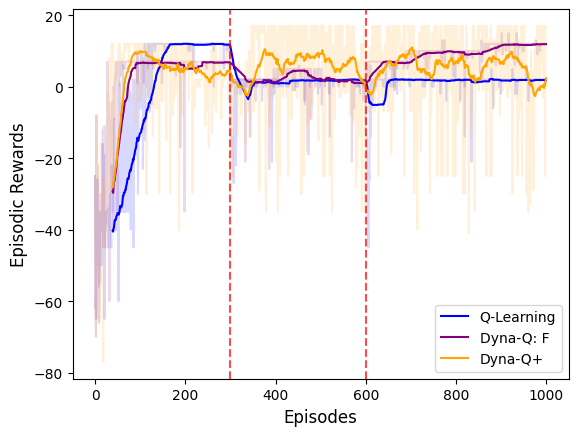

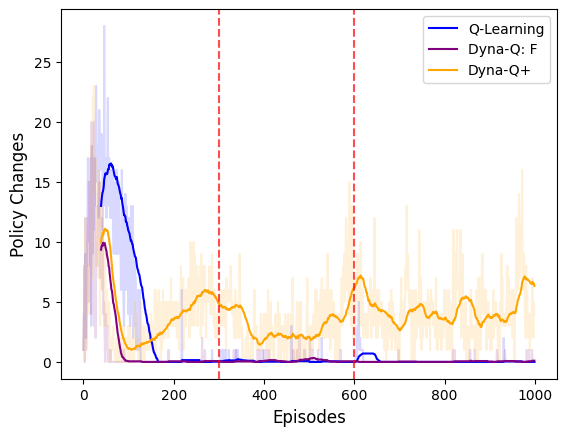

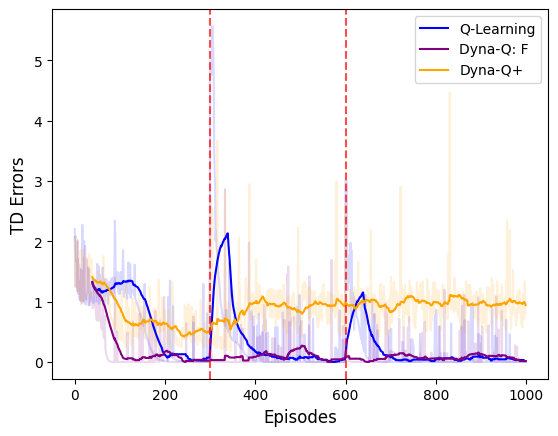

In [16]:
colors = ["blue", "purple", "orange"]
algo_colours = {}
for itm, algo in enumerate(algorithms):
    algo_colours[algo] = colors[itm]
window_size = 40

# Cumulative Rewards Plot
for algo in algorithms:
    rewards_series = pd.Series(data[algo].total_rewards)
    plt.plot(rewards_series, alpha=0.15, color=algo_colours[algo])
for algo in algorithms:
    rewards_series = pd.Series(data[algo].total_rewards)
    rolling_avg = rewards_series.rolling(window=window_size).mean()
    plt.plot(rolling_avg, label=f"{algo}", color=algo_colours[algo])
for change in changes:
    plt.axvline(x=change, color="red", linestyle="--", alpha=0.7)
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Episodic Rewards", fontsize=12)
plt.legend()
if not save:
    plt.title("Episodic Returns with Rolling Averages per Algorithm")
if save:
    plt.savefig("images/episodic_rewards.png", dpi=300)
plt.show()

# Policy Stability (Change in Policy over Time)
for algo in algorithms:
    policy_changes = pd.Series(data[algo].policy_changes)
    plt.plot(policy_changes, alpha=0.15, color=algo_colours[algo])
for algo in algorithms:
    policy_changes = pd.Series(data[algo].policy_changes)
    smoothed_policy_changes = policy_changes.rolling(window=window_size).mean()
    plt.plot(
        smoothed_policy_changes,
        label=f"{algo}",
        color=algo_colours[algo],
    )
for change in changes:
    plt.axvline(x=change, color="red", linestyle="--", alpha=0.7)
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("Policy Changes", fontsize=12)
plt.legend()
if not save:
    plt.title("Policy Changes with Rolling Averages per Algorithm")
if save:
    plt.savefig("images/policy_changes.png", dpi=300)
plt.show()

# TD Errors Smoothed
for algo in algorithms:
    td_errors = pd.Series(data[algo].td_errors)
    plt.plot(td_errors, alpha=0.15, color=algo_colours[algo])
for algo in algorithms:
    td_errors = pd.Series(data[algo].td_errors)
    smoothed_td_errors = td_errors.rolling(window=window_size).mean()
    plt.plot(
        smoothed_td_errors,
        label=f"{algo}",
        color=algo_colours[algo],
    )
for change in changes:
    plt.axvline(x=change, color="red", linestyle="--", alpha=0.7)
plt.xlabel("Episodes", fontsize=12)
plt.ylabel("TD Errors", fontsize=12)
plt.legend()
if not save:
    plt.title("TD Errors with Rolling Averages per Algorithm")
if save:
    plt.savefig("images/td_errors.png", dpi=300)
plt.show()

## Multiple replications

In [233]:
# Multiple replications
np.random.seed(seed)
random.seed(seed)

segment_rewards = {
    "Q-Learning": {0: [], 1: [], 2: []},
    "Dyna-Q: Forgetful": {0: [], 1: [], 2: []},
    # "Dyna-Q Forgetful with Prioritised Sweeping": {0: [], 1: [], 2: []},
    "Dyna-Q+": {0: [], 1: [], 2: []},
}

total_replications = 1000
for rep in range(total_replications):
    seed += 1
    simulator, _ = q_learning(seed=seed, plot=False)
    sim_dyna, _ = dyna_q(seed=seed, plot=False)
    # sim_dyna_sweep, _ = dyna_q_sweep(seed=seed, plot=False)
    sim_dyna_plus, _ = dyna_q_plus(seed=seed, plot=False)

    # Add to rewards
    segment_rewards["Q-Learning"][0].extend(simulator.total_rewards[: changes[0]])
    segment_rewards["Q-Learning"][1].extend(
        simulator.total_rewards[changes[0] : changes[1]]
    )
    segment_rewards["Q-Learning"][2].extend(simulator.total_rewards[changes[1] :])

    segment_rewards["Dyna-Q: Forgetful"][0].extend(sim_dyna.total_rewards[: changes[0]])
    segment_rewards["Dyna-Q: Forgetful"][1].extend(
        sim_dyna.total_rewards[changes[0] : changes[1]]
    )
    segment_rewards["Dyna-Q: Forgetful"][2].extend(sim_dyna.total_rewards[changes[1] :])

    # segment_rewards["Dyna-Q Forgetful with Prioritised Sweeping"][0].extend(
    #     sim_dyna_sweep.total_rewards[: changes[0]]
    # )
    # segment_rewards["Dyna-Q Forgetful with Prioritised Sweeping"][1].extend(
    #     sim_dyna_sweep.total_rewards[changes[0] : changes[1]]
    # )
    # segment_rewards["Dyna-Q Forgetful with Prioritised Sweeping"][2].extend(
    #     sim_dyna_sweep.total_rewards[changes[1] :]
    # )

    segment_rewards["Dyna-Q+"][0].extend(sim_dyna_plus.total_rewards[: changes[0]])
    segment_rewards["Dyna-Q+"][1].extend(
        sim_dyna_plus.total_rewards[changes[0] : changes[1]]
    )
    segment_rewards["Dyna-Q+"][2].extend(sim_dyna_plus.total_rewards[changes[1] :])

In [234]:
# Initialize a dictionary to store mean and max rewards
summary_table = {
    "Algorithm": [],
    "Segment": [],
    "Mean Reward": [],
    "Max Reward": [],
    "SD Rewards": [],
}

# Calculate mean and max rewards for each algorithm and segment
for algorithm, segments in segment_rewards.items():
    for segment, rewards in segments.items():
        mean_reward = sum(rewards) / len(rewards) if rewards else 0
        max_reward = max(rewards) if rewards else 0
        sd_rewards = np.std(rewards)

        summary_table["Algorithm"].append(algorithm)
        summary_table["Segment"].append(segment)
        summary_table["Mean Reward"].append(mean_reward)
        summary_table["Max Reward"].append(max_reward)
        summary_table["SD Rewards"].append(sd_rewards)

In [235]:
# Convert to a Pandas DataFrame for easy viewing
summary_df = pd.DataFrame(summary_table)

In [236]:
summary_df.to_csv("results.csv")